In [1]:
from os import listdir, path
import numpy as np
import scipy
import cv2
import os, sys
from generator import create_model_residual, create_model
from keras.callbacks import ModelCheckpoint, Callback
from glob import glob
import pickle, argparse

os.environ["CUDA_VISIBLE_DEVICES"]="2"

half_window_size = 4
mel_step_size = 27


Using TensorFlow backend.


In [2]:
def frame_id(fname):
    return int(os.path.basename(fname).split('.')[0])

def choose_ip_frame(frames, gt_frame):
    selected_frames = [f for f in frames if np.abs(frame_id(gt_frame) - frame_id(f)) >= 6]
    return np.random.choice(selected_frames)

def get_audio_segment(center_frame, spec):
    center_frame_id = frame_id(center_frame)
    start_frame_id = center_frame_id - half_window_size

    start_idx = int((81./25.) * start_frame_id) # 25 is fps of LRS2
    end_idx = start_idx + mel_step_size

    return spec[:, start_idx : end_idx] if end_idx <= spec.shape[1] else None

def datagen(args):
    all_images = args.all_images
    batch_size = args.batch_size

    while(1):
        np.random.shuffle(all_images)
        batches = [all_images[i:i + args.batch_size] for i in range(0, len(all_images), args.batch_size)]

        for batch in batches:
            img_gt_batch = []
            img_ip_batch = []
            mel_batch = []
            
            for img_name in batch:
                gt_fname = os.path.basename(img_name)
                dir_name = img_name.replace(gt_fname, '')
                frames = glob(dir_name + '/*.jpg')
                if len(frames) < 12:
                    continue

                mel_fname = dir_name + '/mels.npz'
                try:
                    mel = np.load(mel_fname)['spec']
                except:
                    continue

                mel = get_audio_segment(gt_fname, mel)

                if mel is None or mel.shape[1] != mel_step_size:
                    continue

                if sum(np.isnan(mel.flatten())) > 0:
                    continue
                
                img_gt = cv2.imread(img_name)
                img_gt = cv2.resize(img_gt, (args.img_size, args.img_size))

                ip_fname = choose_ip_frame(frames, gt_fname)
                img_ip = cv2.imread(os.path.join(dir_name, ip_fname))
                img_ip = cv2.imread(ip_fname)
                img_ip = cv2.resize(img_ip, (args.img_size, args.img_size))

                img_gt_batch.append(img_gt)
                img_ip_batch.append(img_ip)
                mel_batch.append(mel)

            img_gt_batch = np.asarray(img_gt_batch)
            img_ip_batch = np.asarray(img_ip_batch)
            mel_batch = np.expand_dims(np.asarray(mel_batch), 3)

            img_gt_batch_masked = img_gt_batch.copy()
            img_gt_batch_masked[:, args.img_size//2:,...] = 0.
            img_ip_batch = np.concatenate([img_ip_batch, img_gt_batch_masked], axis=3)
            
            yield [img_ip_batch/255.0, mel_batch], img_gt_batch/255.0


In [3]:
from easydict import EasyDict
args = EasyDict(data_root='LipGAN_dataset',
               logdir='logs_ipynb/',
               model='residual',
               resume='logs/unet_residual.h5',
               #resume=None,
               checkpoint_name='unet_residual_start.h5',
               checkpoint_freq=1000,
               n_gpu=1,
               batch_size=96,
               lr=1e-3,
               img_size=96,
               epochs=20000000,
               all_images='filenames.pkl')
print(args)

{'data_root': 'LipGAN_dataset', 'logdir': 'logs_ipynb/', 'model': 'residual', 'resume': 'logs/unet_residual.h5', 'checkpoint_name': 'unet_residual_start.h5', 'checkpoint_freq': 1000, 'n_gpu': 1, 'batch_size': 96, 'lr': 0.001, 'img_size': 96, 'epochs': 20000000, 'all_images': 'filenames.pkl'}


In [4]:
if not path.exists(args.logdir):
    os.mkdir(args.logdir)
    
if path.exists(path.join(args.logdir, args.all_images)):
    args.all_images = pickle.load(open(path.join(args.logdir, args.all_images), 'rb'))
else:
    all_images = glob(path.join("{}/train/*/*/*.jpg".format(args.data_root)))
    pickle.dump(all_images, open(path.join(args.logdir, args.all_images), 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
    args.all_images = all_images

print ("Will be training on {} images".format(len(args.all_images)))

Will be training on 1678240 images


In [5]:
if args.model == 'residual':
    model = create_model_residual(args, mel_step_size)
else:
    model = create_model(args, mel_step_size)
    

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_face (InputLayer)         (None, 96, 96, 6)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 96, 96, 32)   9440        input_face[0][0]                 
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 96, 96, 32)   128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 96, 96, 32)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [6]:
if args.resume:
    model.load_weights(args.resume)
    print('Resuming from : {}'.format(args.resume))

args.batch_size = args.n_gpu * args.batch_size
train_datagen = datagen(args)

class WeightsSaver(Callback):
    def __init__(self, N, weight_path):
        self.N = N
        self.batch = 0
        self.weight_path = weight_path

    def on_batch_end(self, batch, logs={}):
        self.batch += 1
        if self.batch % self.N == 0:
            self.model.save_weights(self.weight_path)



Resuming from : logs/unet_residual.h5


### Train

In [29]:
callbacks_list = [WeightsSaver(args.checkpoint_freq, path.join(args.logdir, args.checkpoint_name))]
model.fit_generator(train_datagen, steps_per_epoch=len(args.all_images)//args.batch_size, 
                    epochs=args.epochs, verbose=1, initial_epoch=0, callbacks = callbacks_list)


Epoch 1/20000000
   33/17481 [..............................] - ETA: 6:23:18 - loss: 0.1001

KeyboardInterrupt: 

### Inference

In [7]:
for [img_ip_batch, mel_batch], img_gt_batch in train_datagen:
    print(img_ip_batch.shape, mel_batch.shape, img_gt_batch.shape)
    pred = model.predict([img_ip_batch, mel_batch])
    break

(83, 96, 96, 6) (83, 80, 27, 1) (83, 96, 96, 3)


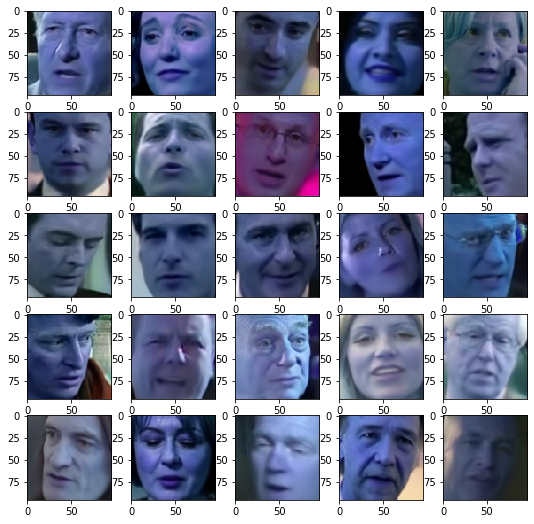

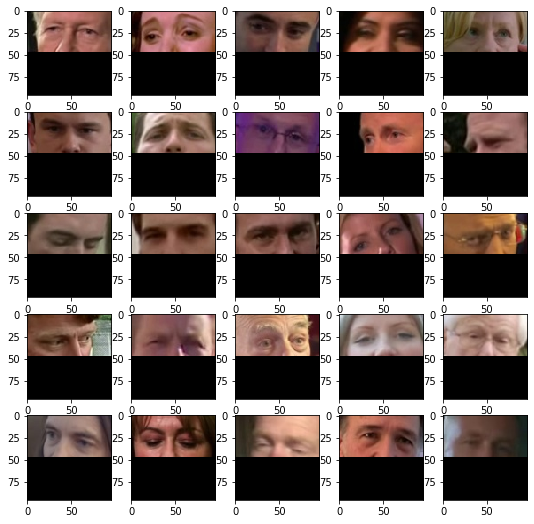

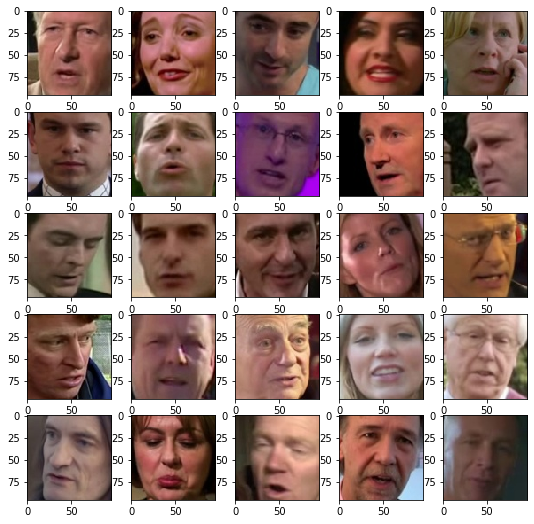

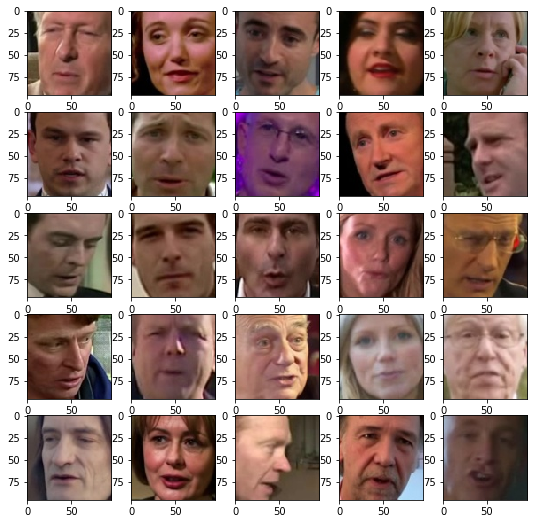

In [8]:
import matplotlib.pyplot as plt
img_ip_batch_rgb = [cv2.cvtColor(img_ip_batch[i, :, :, :3].astype(np.float32), cv2.COLOR_BGR2RGB) for i in range(len(img_ip_batch))]
img_ip_batch_rgb = np.stack(img_ip_batch_rgb)
img_gt_masked_batch_rgb = [cv2.cvtColor(img_ip_batch[i, :, :, 3:].astype(np.float32), cv2.COLOR_BGR2RGB) for i in range(len(img_ip_batch))]
img_gt_masked_batch_rgb = np.stack(img_gt_masked_batch_rgb)
img_gt_batch_rgb = [cv2.cvtColor(img_gt_batch[i, :, :, :3].astype(np.float32), cv2.COLOR_BGR2RGB) for i in range(len(img_gt_batch))]
img_gt_batch_rgb = np.stack(img_gt_batch_rgb)
pred_rgb = [cv2.cvtColor(pred.astype(np.float32), cv2.COLOR_BGR2RGB) for i in range(len(pred))]
pred_rgb = np.stack(pred_rgb)

K = 5
plt.figure(figsize=[9, 9])
plt.title('predict')
for i in range(1, K+1):
    for j in range(1, K+1):
        plt.subplot(K, K, (i - 1) * K + j)
        plt.imshow(pred[(i-1) * K + (j-1)])
plt.show()

plt.figure(figsize=[9, 9])
plt.title('ground truth masked')
for i in range(1, K+1):
    for j in range(1, K+1):
        plt.subplot(K, K, (i - 1) * K + j)
        plt.imshow(img_gt_masked_batch_rgb[(i-1) * K + (j-1), :, :, :3])
plt.show()

plt.figure(figsize=[9, 9])
plt.title('ground truth')
for i in range(1, K+1):
    for j in range(1, K+1):
        plt.subplot(K, K, (i - 1) * K + j)
        plt.imshow(img_gt_batch_rgb[(i-1) * K + (j-1), :, :, :3])
plt.show()

plt.figure(figsize=[9, 9])
plt.title('ip')
for i in range(1, K+1):
    for j in range(1, K+1):
        plt.subplot(K, K, (i - 1) * K + j)
        plt.imshow(img_ip_batch_rgb[(i-1) * K + (j-1), :, :, :3])
plt.show()

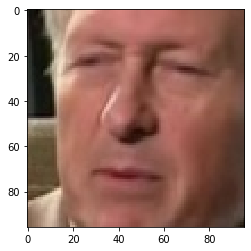

In [9]:
t = img_ip_batch[0, :, :, :3].astype(np.float32)
t = cv2.cvtColor(t, cv2.COLOR_BGR2RGB)

plt.imshow(t)
plt.show()